In [1]:
import torch
import numpy as np

from deep_parity.model import MLPv1 as MLP, Perceptron
from deep_parity.boolean_cube import fourier_transform, get_subcube, generate_all_binary_arrays

from pathlib import Path

import torch
import polars as pl
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns


from plotnine import ggplot, qplot, aes, geom_point, geom_histogram, facet_wrap, labs

/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def make_base_parity_dataframe(n):
    all_binary_data = generate_all_binary_arrays(n).astype(np.int32)
    #all_binary_data = np.sign(-1 * all_binary_data_zero_one + 0.5)
    all_parities = all_binary_data.sum(axis=1) % 2
    base_df = pl.DataFrame({
        'bits': all_binary_data, 
        'parities': all_parities, 
    })
    base_df = base_df.with_columns(
        indices=pl.col('bits').arr.to_list().list.eval(pl.arg_where(pl.element() == 1)),
        degree=pl.col('bits').arr.sum()
    )
    return base_df


def calc_power_contributions(tensor, n, epoch):
    linear_dim = tensor.shape[1]
    base_df = make_base_parity_dataframe(n)
    ft = fourier_transform(tensor.T)
    ft /= ft.mean(dim=0, keepdims=True)
    linear_df = pl.DataFrame(
        ft.T.detach().cpu().numpy(),
        schema=[str(i) for i in range(linear_dim)]
    )
    data = pl.concat([base_df, linear_df], how='horizontal')
    total_power = (
        data
        .select(pl.exclude('bits', 'parities', 'indices', 'degree'))
        .unpivot()
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('variable').agg(pl.col('value').pow(2).sum())
        .rename({'value': 'power'})
    )
    power_df = (
        data
        .select(pl.exclude('bits', 'parities', 'indices'))
        .unpivot(index='degree')
        .with_columns(pl.col('variable').str.to_integer())
        .group_by('degree', 'variable').agg(pl.col('value').pow(2).sum())
        .join(total_power, on='variable', how='left')
        .with_columns(pcnt_power = pl.col('value') / pl.col('power'), epoch=pl.lit(epoch))
    )
    return power_df

In [2]:
checkpoint_dir = Path('checkpoints/19')
epoch = 18_000
model_run = torch.load(checkpoint_dir / f'{epoch}.pth', map_location='cpu', weights_only=True)
config = model_run['config']

model = Perceptron(config['n'], config['model_dim'])
model.load_state_dict(model_run['model'])

<All keys matched successfully>

In [5]:
n = 19
boolean_cube_df = make_base_parity_dataframe(n)
boolean_cube = -1 * torch.sign(torch.from_numpy(generate_all_binary_arrays(n)).to(torch.float32) - 0.5)

In [6]:
from torch.nn.functional import relu

l1_outs = relu(model.linear(boolean_cube))
l1_ft = fourier_transform(l1_outs.T).T

/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 160'. Pick better value with 'binwidth'.
/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 160'. Pick better value with 'binwidth'.


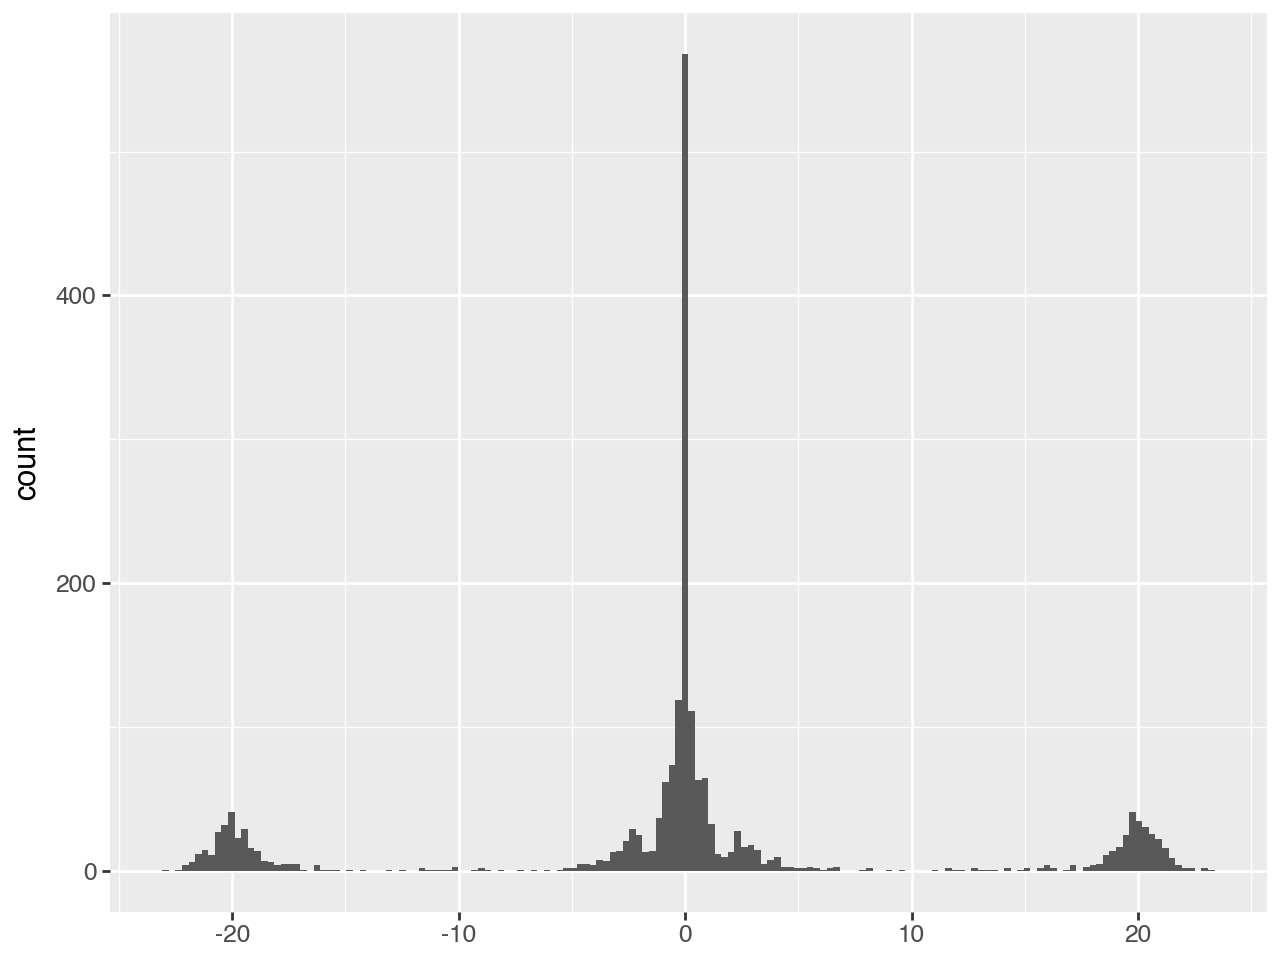

In [75]:
qplot(l1_ft[-1, :].detach().numpy()) + geom_histogram()

In [13]:
(
    
    * 
    * 
)

tensor([-1., -1., -1.,  ..., -1., -1.,  1.])

In [19]:
w_parity_bias_agree = torch.sign(model.linear.weight.detach()).prod(dim=1) * torch.sign(model.linear.bias.detach())

In [52]:
bias_mask = (model.linear.bias.detach().abs() > 0.2)

In [74]:
bias_mask = (model.linear.bias.detach().abs() >= 0.3)
print(bias_mask.sum())
w_parity = torch.sign(model.linear.weight.detach()).prod(dim=1)[bias_mask]
bias_sign = torch.sign(model.linear.bias.detach())[bias_mask]
unembed_sign = torch.sign(model.unembed.weight[1].detach())[bias_mask]
((w_parity * bias_sign * unembed_sign) == 1).sum()

tensor(352)


tensor(296)

In [73]:
1057 / 1696

0.6232311320754716

In [64]:
sum(bias_mask)

tensor(1046)

/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 20'. Pick better value with 'binwidth'.
/Users/dashiell/workspace/deep-parity/.venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 20'. Pick better value with 'binwidth'.


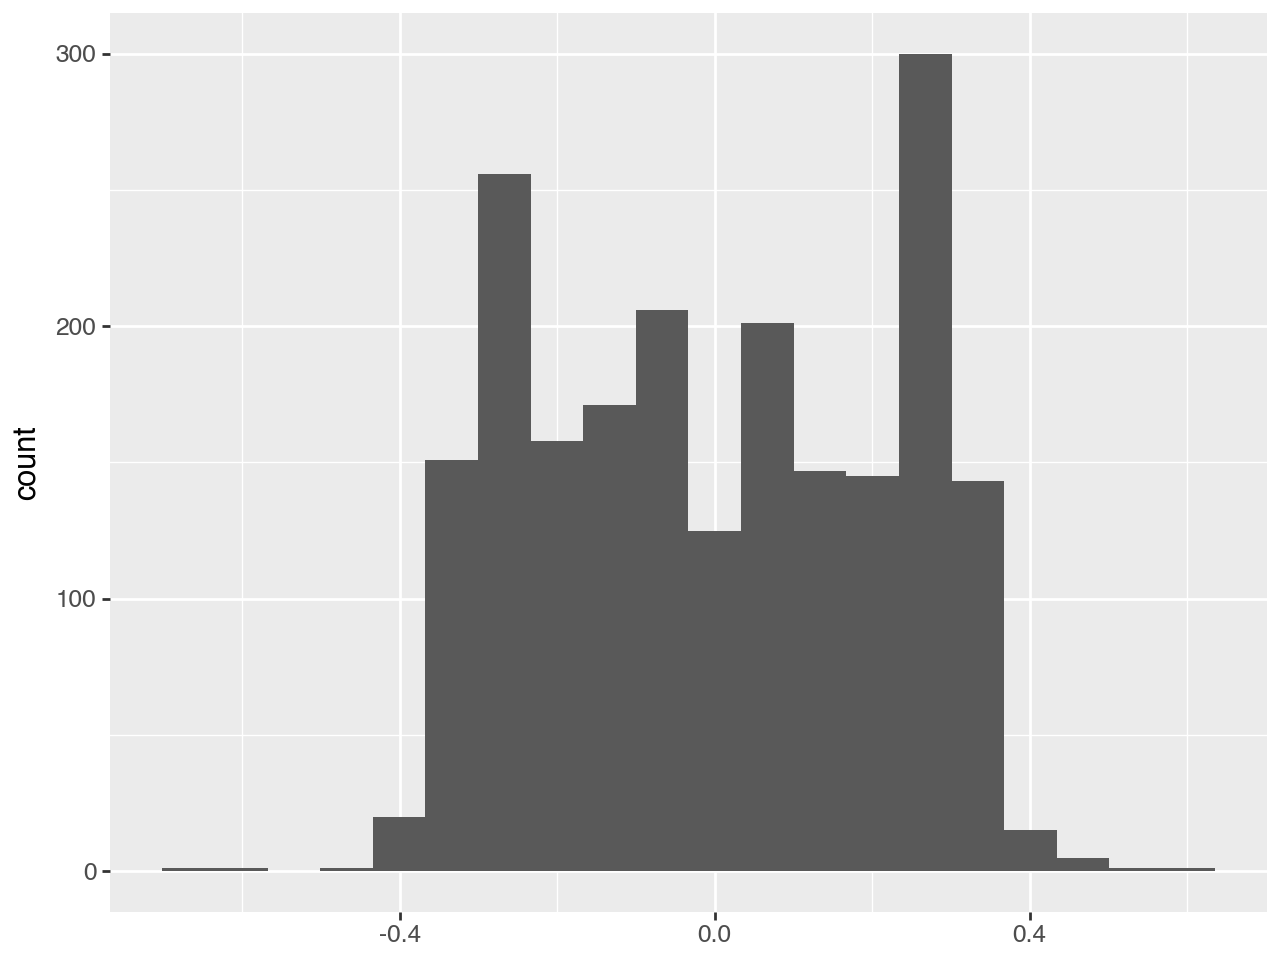

In [44]:
qplot(model.linear.bias.detach().numpy()) + geom_histogram()

In [36]:
((torch.sign(model.unembed.weight[0].detach()) * w_parity_bias_agree) == 1).sum()

tensor(696)

In [7]:
l1_ft_df = pl.concat([boolean_cube_df, pl.DataFrame(l1_ft.detach().numpy(), schema=[str(i) for i in range(2048)])], how='horizontal')
l1_ft_df = l1_ft_df.lazy()

In [8]:
l1_outs_df =  pl.concat([boolean_cube_df, pl.DataFrame(l1_outs.detach().numpy(), schema=[str(i) for i in range(2048)])], how='horizontal')

In [9]:
l1_outs_df = l1_outs_df.with_columns(parities=boolean_cube_df['parities'])

In [13]:

def calc_influence(data, idx):
    df = (
        data
        .filter(pl.col('indices').list.contains(idx))
        .select(pl.exclude(['bits', 'parities', 'degree', 'indices']))
        .unpivot()
        .group_by('variable')
        .agg(pl.col('value').pow(2).sum().alias(f'inf{idx}'))
        .with_columns(pl.col('variable').cast(pl.Int32))
        .sort('variable')
        .select(f'inf{idx}')
        .collect(streaming=True)
    )
    return df
    

inf_data = pl.DataFrame({f'inf{i}': calc_influence(l1_ft_df, i) for i in range(18)})
    

In [15]:
inf_data = inf_data.with_row_index()

In [20]:
i = 2
inf_data.select('index', f'inf{i}').sort(f'inf{i}', descending=True)

index,inf2
u32,f32
208,43615.0625
2037,30278.90625
1815,29243.388672
253,27468.464844
83,27305.894531
…,…
1599,5.516102
858,4.053802
1695,2.572614


In [33]:
chow_indices = torch.argwhere((boolean_cube == -1).sum(dim=1) <= 1).squeeze()
chow_params = l1_ft[chow_indices, :]

In [34]:
chow_params = chow_params.detach().numpy().T



In [35]:
chow_params.shape

(2048, 19)

(2048,)
(2048, 18)


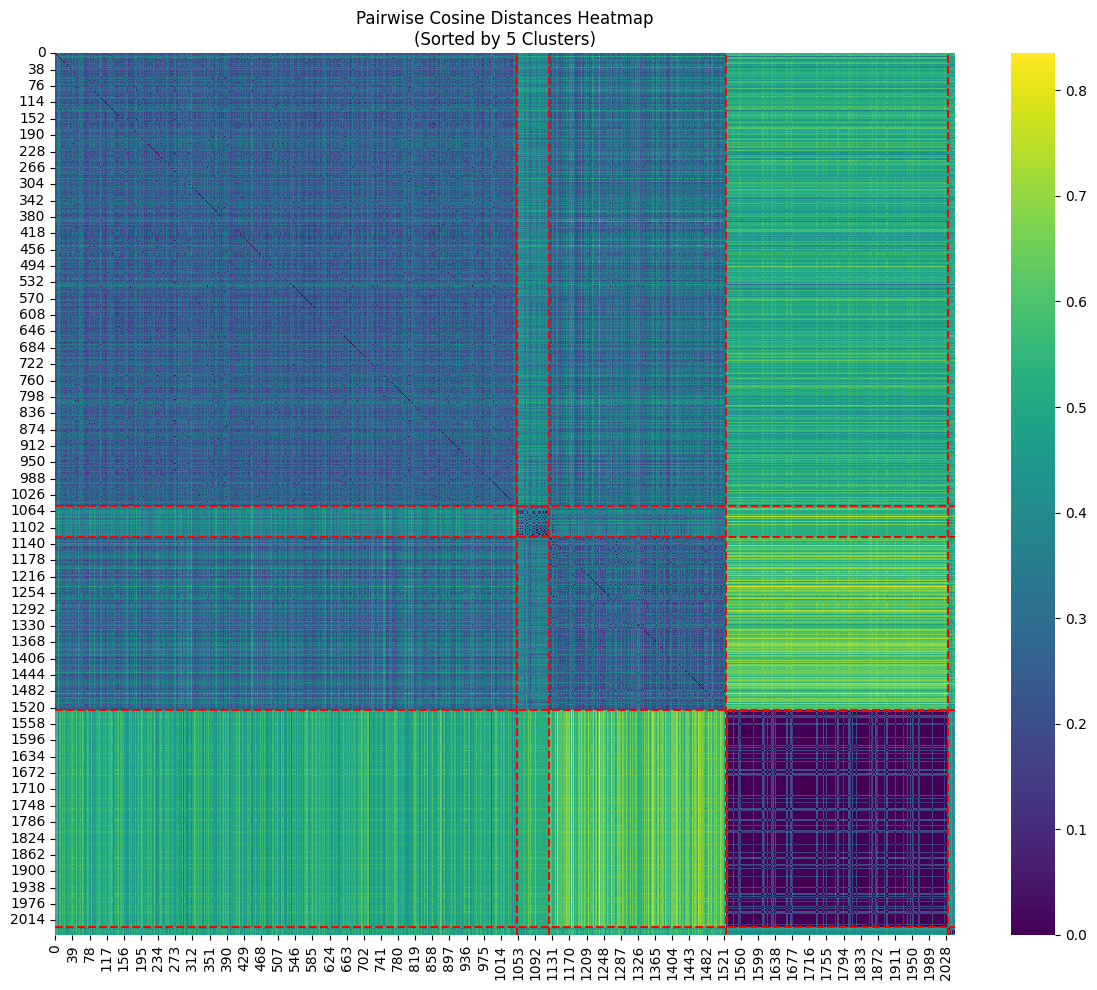

In [48]:


def canonicalize_chow_parameters(chow_params):
    """
    Canonicalize Chow parameters by taking absolute values and sorting in decreasing order.
    """
    new_params = np.sort(np.abs(chow_params), axis=1)[:, ::-1]
    norm = np.linalg.norm(new_params, axis=1)
    return new_params / norm[:, None], norm


def compute_pairwise_distances(canonicalized_params):
    """
    Compute pairwise cosine distances between canonicalized Chow parameters.
    """
    return pdist(canonicalized_params, metric='euclidean')


def cluster_neurons(distances, n_clusters=5):
    """
    Cluster neurons based on their pairwise distances.
    """
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    return clustering.fit_predict(squareform(distances))


def plot_distance_heatmap(distances, clustering, n_clusters):
    """
    Plot a heatmap of the pairwise distances with clustering.
    """
    # Convert distances to a square matrix
    dist_matrix = squareform(distances)
    
    # Sort the matrix based on clustering
    sorted_indices = np.argsort(clustering)
    sorted_matrix = dist_matrix[sorted_indices][:, sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(sorted_matrix, cmap='viridis')
    
    # Add cluster separation lines
    cluster_sizes = np.bincount(clustering)
    cumulative_sizes = np.cumsum(cluster_sizes)
    for size in cumulative_sizes[:-1]:
        plt.axhline(y=size, color='red', linestyle='--')
        plt.axvline(x=size, color='red', linestyle='--')
    
    plt.title(f'Pairwise Cosine Distances Heatmap\n(Sorted by {n_clusters} Clusters)')
    plt.tight_layout()
    plt.show()


def plot_multiple_heatmaps(distances, cluster_numbers=[2, 5, 10]):
    for n_clusters in cluster_numbers:
        clustering = cluster_neurons(distances, n_clusters=n_clusters)
        plot_distance_heatmap(distances, clustering, n_clusters)



chow_biases = chow_params[:, 0]
chow_input_params = chow_params[:, 1:]

canon_params, param_norm = canonicalize_chow_parameters(chow_input_params)
canon_bias = chow_biases / param_norm
distances = compute_pairwise_distances(np.concat([canon_bias[:, None], canon_params], axis=1))

# Function to plot heatmaps for different numbers of clusters
plot_multiple_heatmaps(distances, cluster_numbers=[5])

In [51]:
cluster_ids = cluster_neurons(distances, 5)

In [54]:
cluster_idx = {i: np.argwhere(cluster_ids == i).squeeze() for i in range(5)}

In [56]:
for i, cluster in cluster_idx.items():
    print(i, len(cluster))

0 1052
1 72
2 402
3 505
4 17


In [63]:
from random import choice


for _ in range(10):
    idx = choice(cluster_idx[3])
    order = torch.argsort(model.linear.weight[idx].abs())
    print(idx, model.linear.weight[idx, order])

1639 tensor([-0.2648, -0.2648, -0.2648,  0.2648, -0.2648,  0.2648,  0.2648,  0.2648,
         0.2648,  0.2648,  0.2648, -0.2648,  0.2648,  0.2648,  0.2648,  0.2648,
         0.2648,  0.2648], grad_fn=<IndexBackward0>)
556 tensor([ 0.3187,  0.3187,  0.3187,  0.3187, -0.3187,  0.3187, -0.3187, -0.3187,
        -0.3187,  0.3187, -0.3187, -0.3187,  0.3187, -0.3187,  0.3187,  0.3187,
        -0.3187, -0.3187], grad_fn=<IndexBackward0>)
1309 tensor([-0.1797, -0.1797, -0.1797,  0.1797, -0.1797,  0.1797,  0.1797, -0.1797,
         0.1797, -0.1797, -0.1797, -0.1797,  0.1797,  0.1797, -0.1797,  0.1797,
         0.1797,  0.1797], grad_fn=<IndexBackward0>)
344 tensor([ 0.3174,  0.3174, -0.3174, -0.3174,  0.3174, -0.3174,  0.3174, -0.3174,
         0.3174,  0.3174,  0.3174, -0.3174,  0.3174, -0.3174, -0.3174,  0.3174,
         0.3174, -0.3174], grad_fn=<IndexBackward0>)
1175 tensor([ 0.3070,  0.3070,  0.3070, -0.3070, -0.3070, -0.3070, -0.3070, -0.3070,
        -0.3070,  0.3070,  0.3070, -0.3070, -

In [73]:
maj_idx

tensor([  10,   13,   14,   15,   16,   18,   24,   25,   28,   30,   43,   45,
          47,   49,   50,   53,   55,   58,   71,   72,   76,   79,   82,   88,
         103,  104,  115,  118,  121,  126,  130,  140,  150,  151,  153,  155,
         156,  158,  172,  182,  184,  185,  186,  188,  190,  191,  196,  197,
         198,  202,  203,  206,  214,  218,  220,  230,  238,  239,  240,  241,
         247,  248,  249,  255,  257,  258,  259,  260,  261,  265,  272,  279,
         283,  286,  293,  294,  296,  297,  306,  309,  311,  313,  316,  321,
         338,  339,  341,  344,  347,  361,  365,  367,  372,  379,  380,  381,
         388,  390,  395,  402,  404,  409,  410,  411,  424,  425,  427,  430,
         431,  446,  449,  452,  457,  461,  464,  470,  471,  473,  474,  476,
         482,  490,  491,  494,  500,  503,  506,  507,  508,  510,  512,  516,
         517,  520,  521,  528,  537,  539,  546,  553,  555,  556,  561,  563,
         565,  567,  569,  575,  582,  5

In [96]:
bias_mask = (model.linear.bias.abs() < 0.01)

(torch.sign(model.linear.weight[maj_mask & bias_mask]).prod(dim=1) * torch.sign(model.unembed.weight[1, maj_mask & bias_mask]) == 1.).sum()

tensor(373)

In [94]:
l1_ft_df.filter(pl.col('degree').eq(18)).select([str(i.item()) for i in maj_no_bias_idx]).unpivot().collect()

variable,value
str,f32
"""10""",-9.968034
"""13""",-16.203934
"""15""",10.241304
"""16""",-19.400061
"""18""",10.107306
…,…
"""2016""",15.239943
"""2021""",-16.177902
"""2023""",16.320126


In [83]:
maj_no_bias_idx

tensor([  10,   13,   15,   16,   18,   24,   28,   30,   43,   45,   49,   50,
          53,   55,   58,   71,   82,   88,  103,  104,  115,  118,  121,  130,
         140,  150,  153,  172,  182,  184,  185,  188,  190,  191,  196,  197,
         202,  203,  206,  214,  218,  220,  230,  238,  239,  240,  241,  247,
         248,  249,  255,  257,  258,  259,  260,  261,  279,  283,  286,  293,
         294,  296,  297,  306,  309,  311,  316,  321,  338,  339,  341,  344,
         347,  361,  367,  372,  379,  380,  381,  390,  395,  404,  410,  411,
         424,  425,  427,  430,  431,  452,  457,  461,  471,  473,  474,  476,
         490,  491,  494,  503,  507,  510,  512,  516,  520,  521,  537,  539,
         546,  555,  556,  561,  563,  565,  567,  569,  575,  586,  589,  594,
         619,  621,  630,  638,  666,  667,  669,  673,  675,  691,  695,  697,
         705,  712,  717,  718,  720,  723,  726,  728,  733,  734,  738,  746,
         763,  768,  788,  789,  790,  8

In [72]:
maj_mask = model.linear.weight.abs().var(dim=1) < 1.e-5
maj_idx = torch.argwhere(maj_mask).squeeze()
maj_bias_idx = torch.argwhere(maj_mask & (model.linear.bias.abs() > 0.01)).squeeze()
maj_no_bias_idx = torch.argwhere(maj_mask & (model.linear.bias.abs() <= 0.01)).squeeze()

In [18]:
#maj_idx = torch.argwhere(model.linear.weight.abs().var(dim=1) < 1.e-5).squeeze()
maj_bias_logits = (l1_outs[:, maj_bias_idx] @ model.unembed.weight[0, maj_bias_idx]).detach().numpy()
maj_nb_logits =  (l1_outs[:, maj_no_bias_idx] @ model.unembed.weight[0, maj_no_bias_idx]).detach().numpy()
maj_df = boolean_cube_df.with_columns(bias_logits = maj_bias_logits, nb_logits = maj_nb_logits)

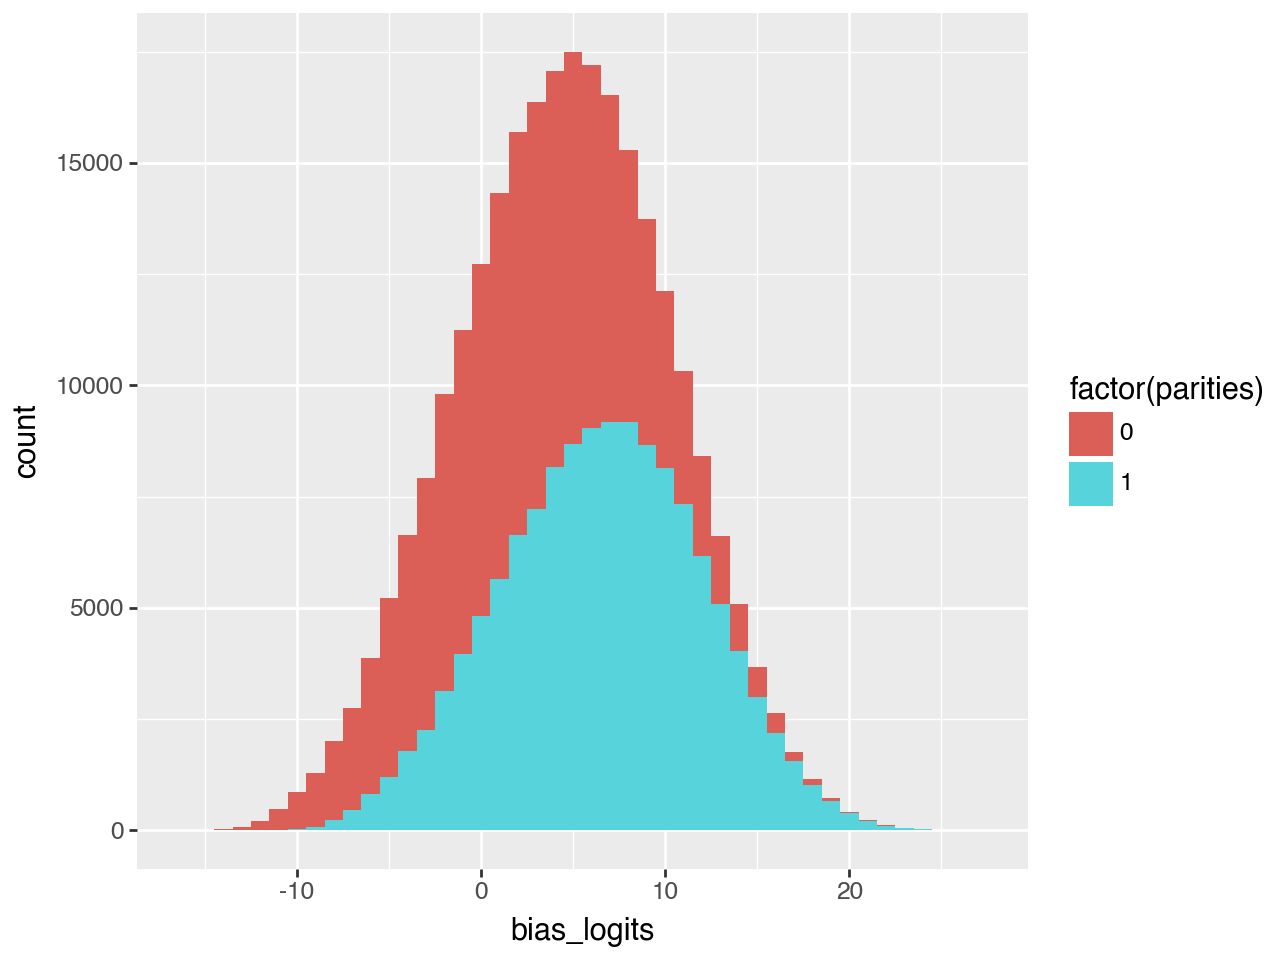

In [19]:
ggplot(maj_df, aes(x='bias_logits', fill='factor(parities)')) + geom_histogram(binwidth=1)

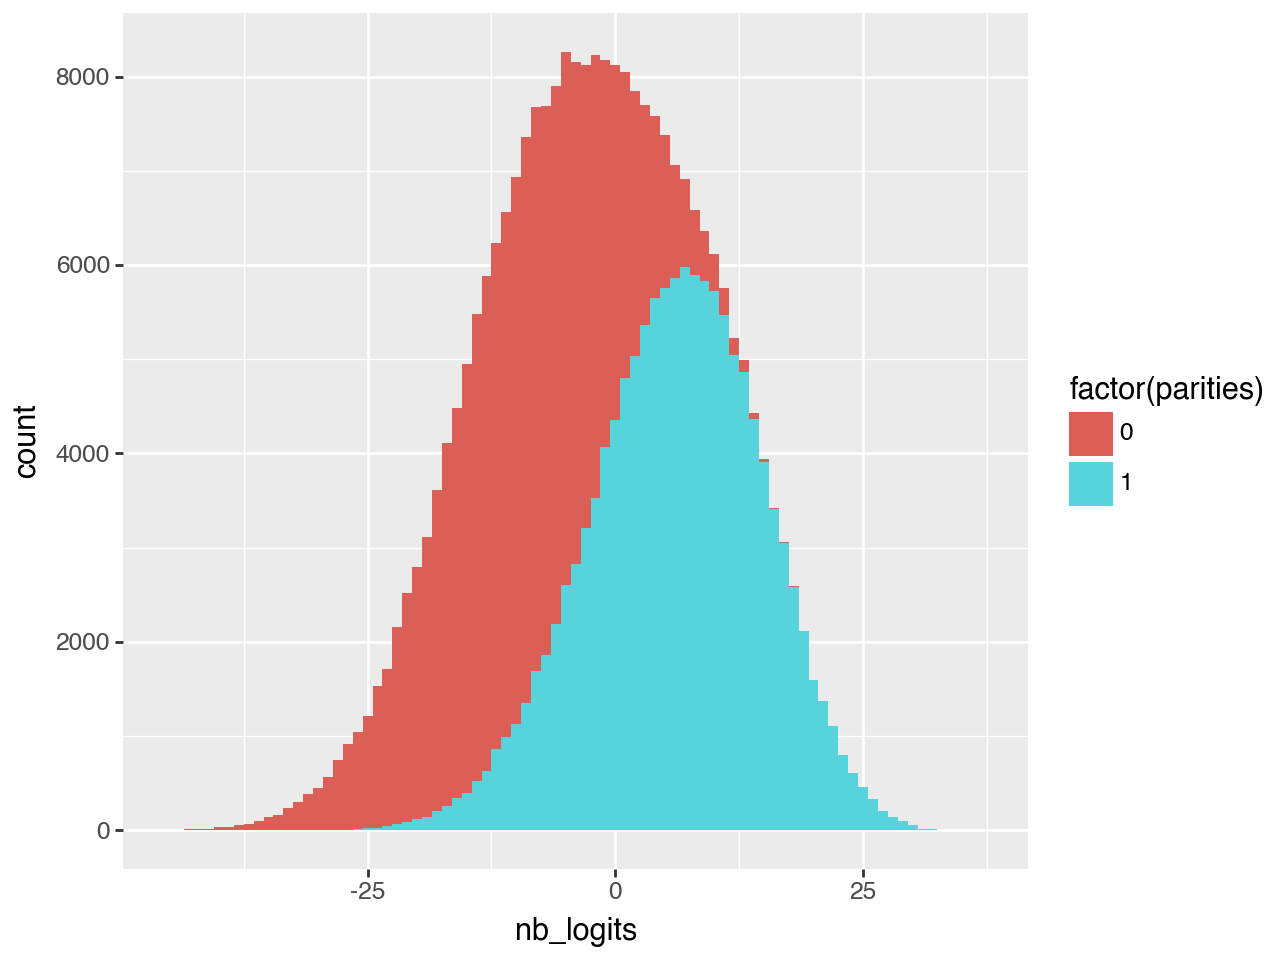

In [20]:
ggplot(maj_df, aes(x='nb_logits', fill='factor(parities)')) + geom_histogram(binwidth=1)

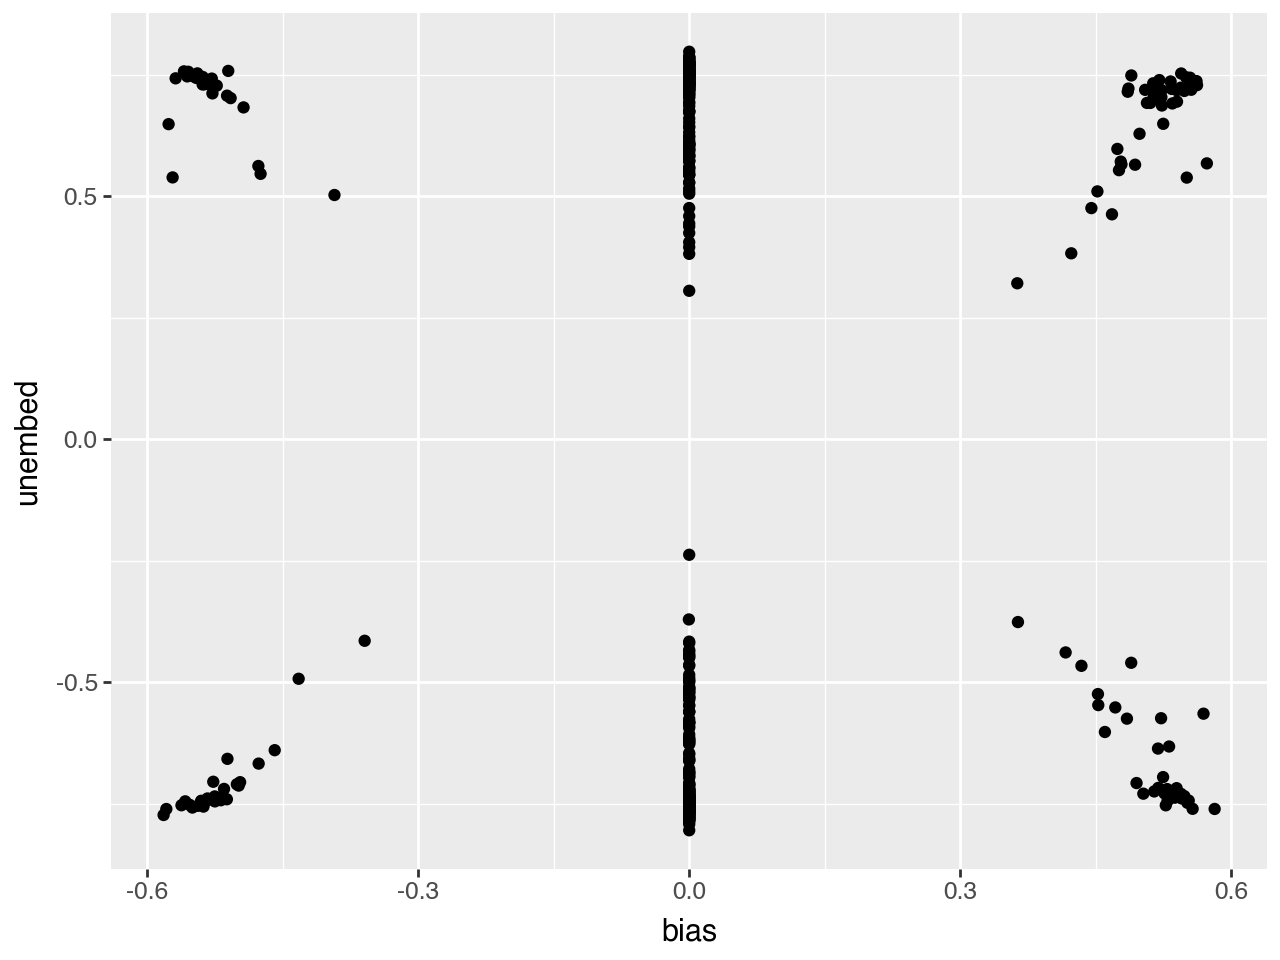

In [22]:

weight_df = pl.DataFrame({
    'unembed': model.unembed.weight[0, maj_idx].detach().numpy(), 
    'bias': model.linear.bias[maj_idx].detach().numpy()}
)


ggplot(weight_df, aes(x='bias', y='unembed')) + geom_point()

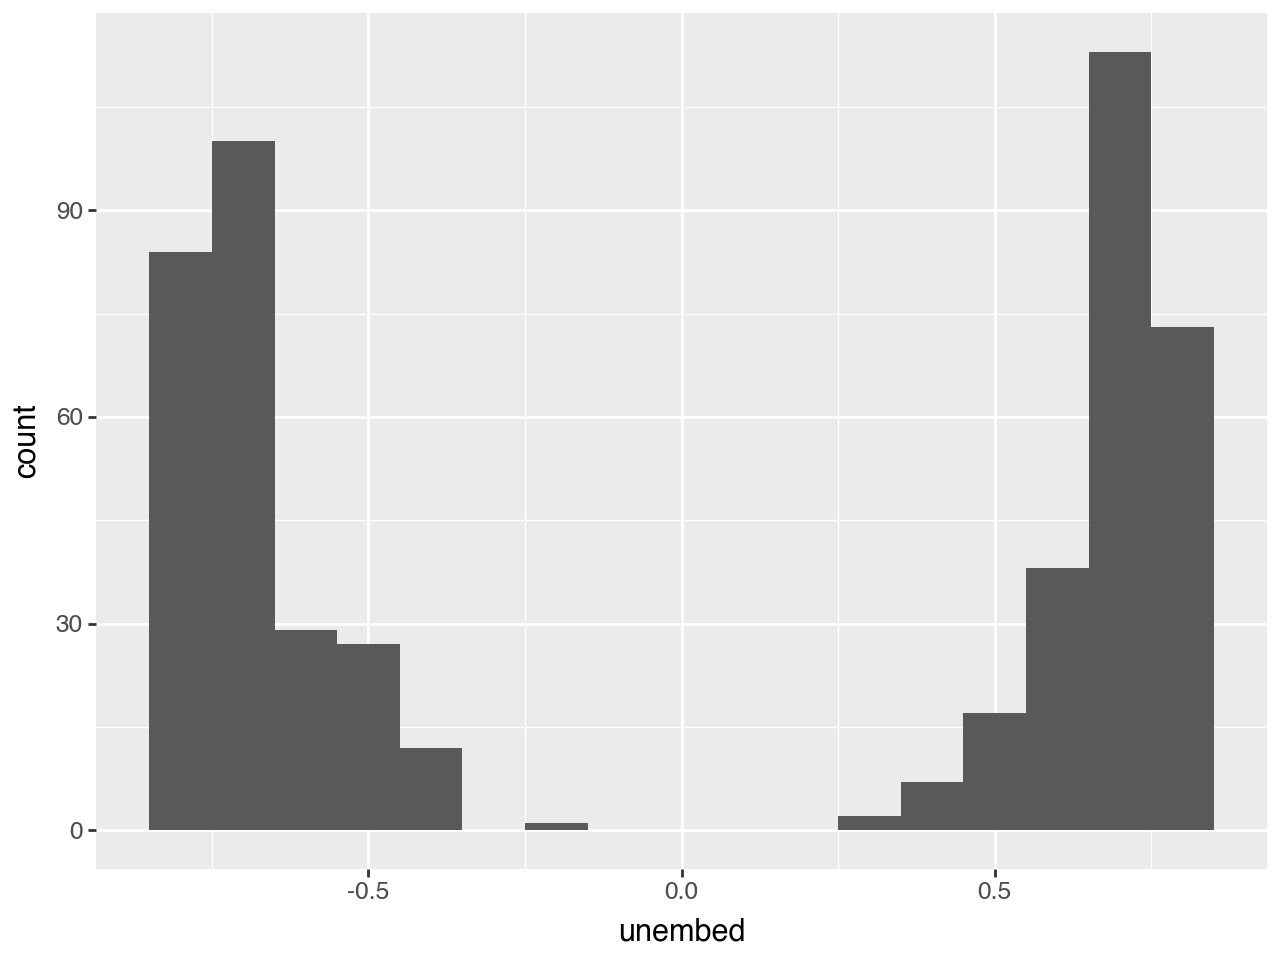

In [23]:
ggplot(weight_df, aes( x='unembed')) + geom_histogram(binwidth=0.1)

In [24]:
maj_idx = torch.argwhere(model.linear.weight.abs().var(dim=1) < 1.e-5).squeeze()
maj_logits = (l1_outs[:, maj_idx] @ model.unembed.weight[1, maj_idx]).detach().numpy()

maj_df = boolean_cube_df.with_columns(maj_logits = maj_logits)

In [25]:
(torch.sign(model.linear.weight[maj_idx]).prod(dim=1) == torch.sign(model.unembed.weight[0, maj_idx])).sum()

tensor(130)

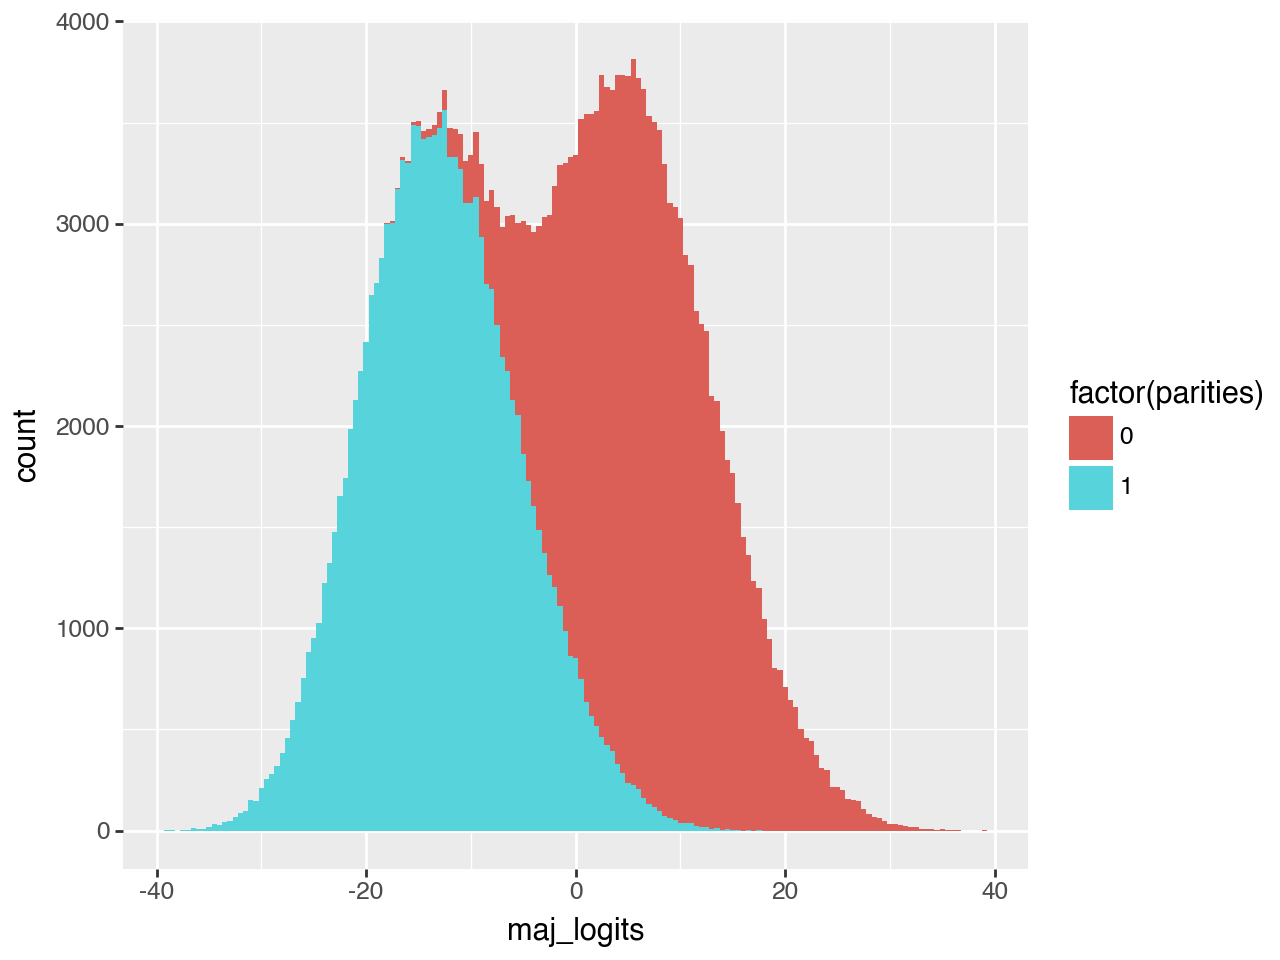

In [26]:
ggplot(maj_df, aes(x='maj_logits', fill='factor(parities)')) + geom_histogram(binwidth=0.5)

In [28]:
def count_approx_unique(weights, tol=1e-2):
    abs_weights = np.abs(weights).round(decimals=int(-np.log10(tol)))
    return np.unique(abs_weights)




distinct_weights = [count_approx_unique(w) for w in model.linear.weight.detach().numpy()]



In [ ]:
numbered_weights = {num: [i for i, w in enumerate(distinct_weights) if len(w) == num] for num in range(2, 19) }


In [ ]:
i = choice(numbered_weights[18])
idx = torch.argsort(-model.linear.weight.detach().abs()[i])
w = model.linear.weight.detach()[i, idx]
w /= w.pow(2).sum().sqrt()
w

In [ ]:
[(w[i] / w[-2]).item() for i in range(18)]

In [ ]:
from itertools import chain

two_through_five = sorted(chain.from_iterable([numbered_weights[i] for i in  range(2, 15)]))

two_val_logits = (l1_outs[:, two_through_five] @ model.unembed.weight[0, two_through_five]).detach().numpy()
maj_idx = torch.argwhere(model.linear.weight.abs().var(dim=1) < 1.e-5).squeeze()
maj_logits = (l1_outs[:, maj_idx] @ model.unembed.weight[0, maj_idx]).detach().numpy()

maj_df = boolean_cube_df.with_columns(multi_logits = two_val_logits, maj_logits = maj_logits, both = maj_logits + two_val_logits )

In [ ]:
legible = set(maj_idx.tolist()).union(set(two_through_five))
other_idx = list(set(range(2048)) - legible)

In [ ]:
len(other_idx)

In [ ]:
other_logits = (l1_outs[:, other_idx] @ model.unembed.weight[0, other_idx]).detach().numpy()
maj_df = maj_df.with_columns(other_logits = other_logits)


In [ ]:
from plotnine import geom_density

(
    ggplot(maj_df.filter(pl.col('degree').is_between(2, 16)), aes(x='other_logits', fill='factor(parities)')) 
    + geom_density(alpha=0.5)
    + facet_wrap('~degree') 
    + theme(figure_size=(14, 14))
)

In [ ]:
from plotnine import geom_density

(
    ggplot(maj_df.filter(pl.col('degree').is_between(2, 16)), aes(x='maj_logits', fill='factor(parities)')) 
    + geom_density(alpha=0.5)
    + facet_wrap('~degree') 
    + theme(figure_size=(14, 14))
)

In [ ]:
(
    ggplot(maj_df.filter(pl.col('degree').is_between(2, 16)), aes(x='multi_logits', fill='factor(parities)')) 
    + geom_density(alpha=0.5)
    + facet_wrap('~degree') 
    + theme(figure_size=(14, 14))
)

In [ ]:
(
    ggplot(maj_df, aes(x='multi_logits', y='maj_logits')) 
    + geom_point(size=0.1, alpha=0.02) 
    + facet_wrap('~parities')
)

In [ ]:
df = maj_df.select(pl.exclude(['bits', 'degree', 'indices'])).unpivot(index='parities')

ggplot(df, aes(x='value', fill='factor(parities)')) + geom_histogram(binwidth=1) + facet_wrap('~variable') + theme(figure_size=(14, 14))

In [ ]:
i = choice(other_idx)
idx = torch.argsort(-model.linear.weight.detach().abs()[i])
w = model.linear.weight.detach()[i, idx]
w /= w.pow(2).sum().sqrt()
print(count_approx_unique(w.numpy()))
print(w)

In [ ]:
triu_idx = torch.triu_indices(2048, 2048, 1) 

similarities = (torch.sign(torch.sign(model.linear.weight)) @ torch.sign(model.linear.weight).T)[triu_idx[0], triu_idx[1]].detach().numpy()

In [ ]:
idx18 = torch.argwhere((torch.sign(torch.sign(model.linear.weight)) @ torch.sign(model.linear.weight).T).abs() == 18)
idx18 = idx18[idx18[:, 0] != idx18[:, 1]].tolist()


In [ ]:
i, j = choice(idx18)
#idx_i = torch.argsort(-model.linear.weight.detach().abs()[i])
#idx_j = torch.argsort(-model.linear.weight.detach().abs()[j])
wi = model.linear.weight.detach()[i]
norm_i = wi.pow(2).sum().sqrt()
wi /= norm_i


wj = model.linear.weight.detach()[j]
norm_j = wj.pow(2).sum().sqrt()
wj /= norm_j

print(wi, (model.linear.bias[i] / norm_i).item(), )
print(wj, (model.linear.bias[j] / norm_j).item())

In [ ]:
unemb_i = model.unembed.weight[1, i].item()
unemb_j = model.unembed.weight[1, j].item()

In [ ]:


xi = torch.sign(model.linear.weight[i, :])
trans_degree = (boolean_cube @ x).detach().numpy()


df = (
    l1_outs_df.select(['parities', 'degree', str(i), str(j)])
    .with_columns(
        trans_degree = trans_degree,
        logits = (unemb_i * pl.col(str(i)) + unemb_j * pl.col(str(j)))
    )
)



In [ ]:
(
    ggplot(df, aes(x=str(i), y=str(j), color='factor(parities)')) 
    + geom_point(alpha=0.2, size=0.2)
)

In [ ]:
(
    ggplot(df, aes(x='degree', y='logits', color='factor(parities)')) 
    + geom_point(alpha=0.2)
)

In [ ]:
df = pl.DataFrame({"sims": similarities})

ggplot(df, aes(x='sims')) + geom_histogram(binwidth=0.5)

In [29]:
maj_cols = maj_idx.tolist()

tensor([[18.,  4.,  0.,  4.],
        [ 4., 18.,  2., -2.],
        [ 0.,  2., 18., -2.],
        [ 4., -2., -2., 18.]])


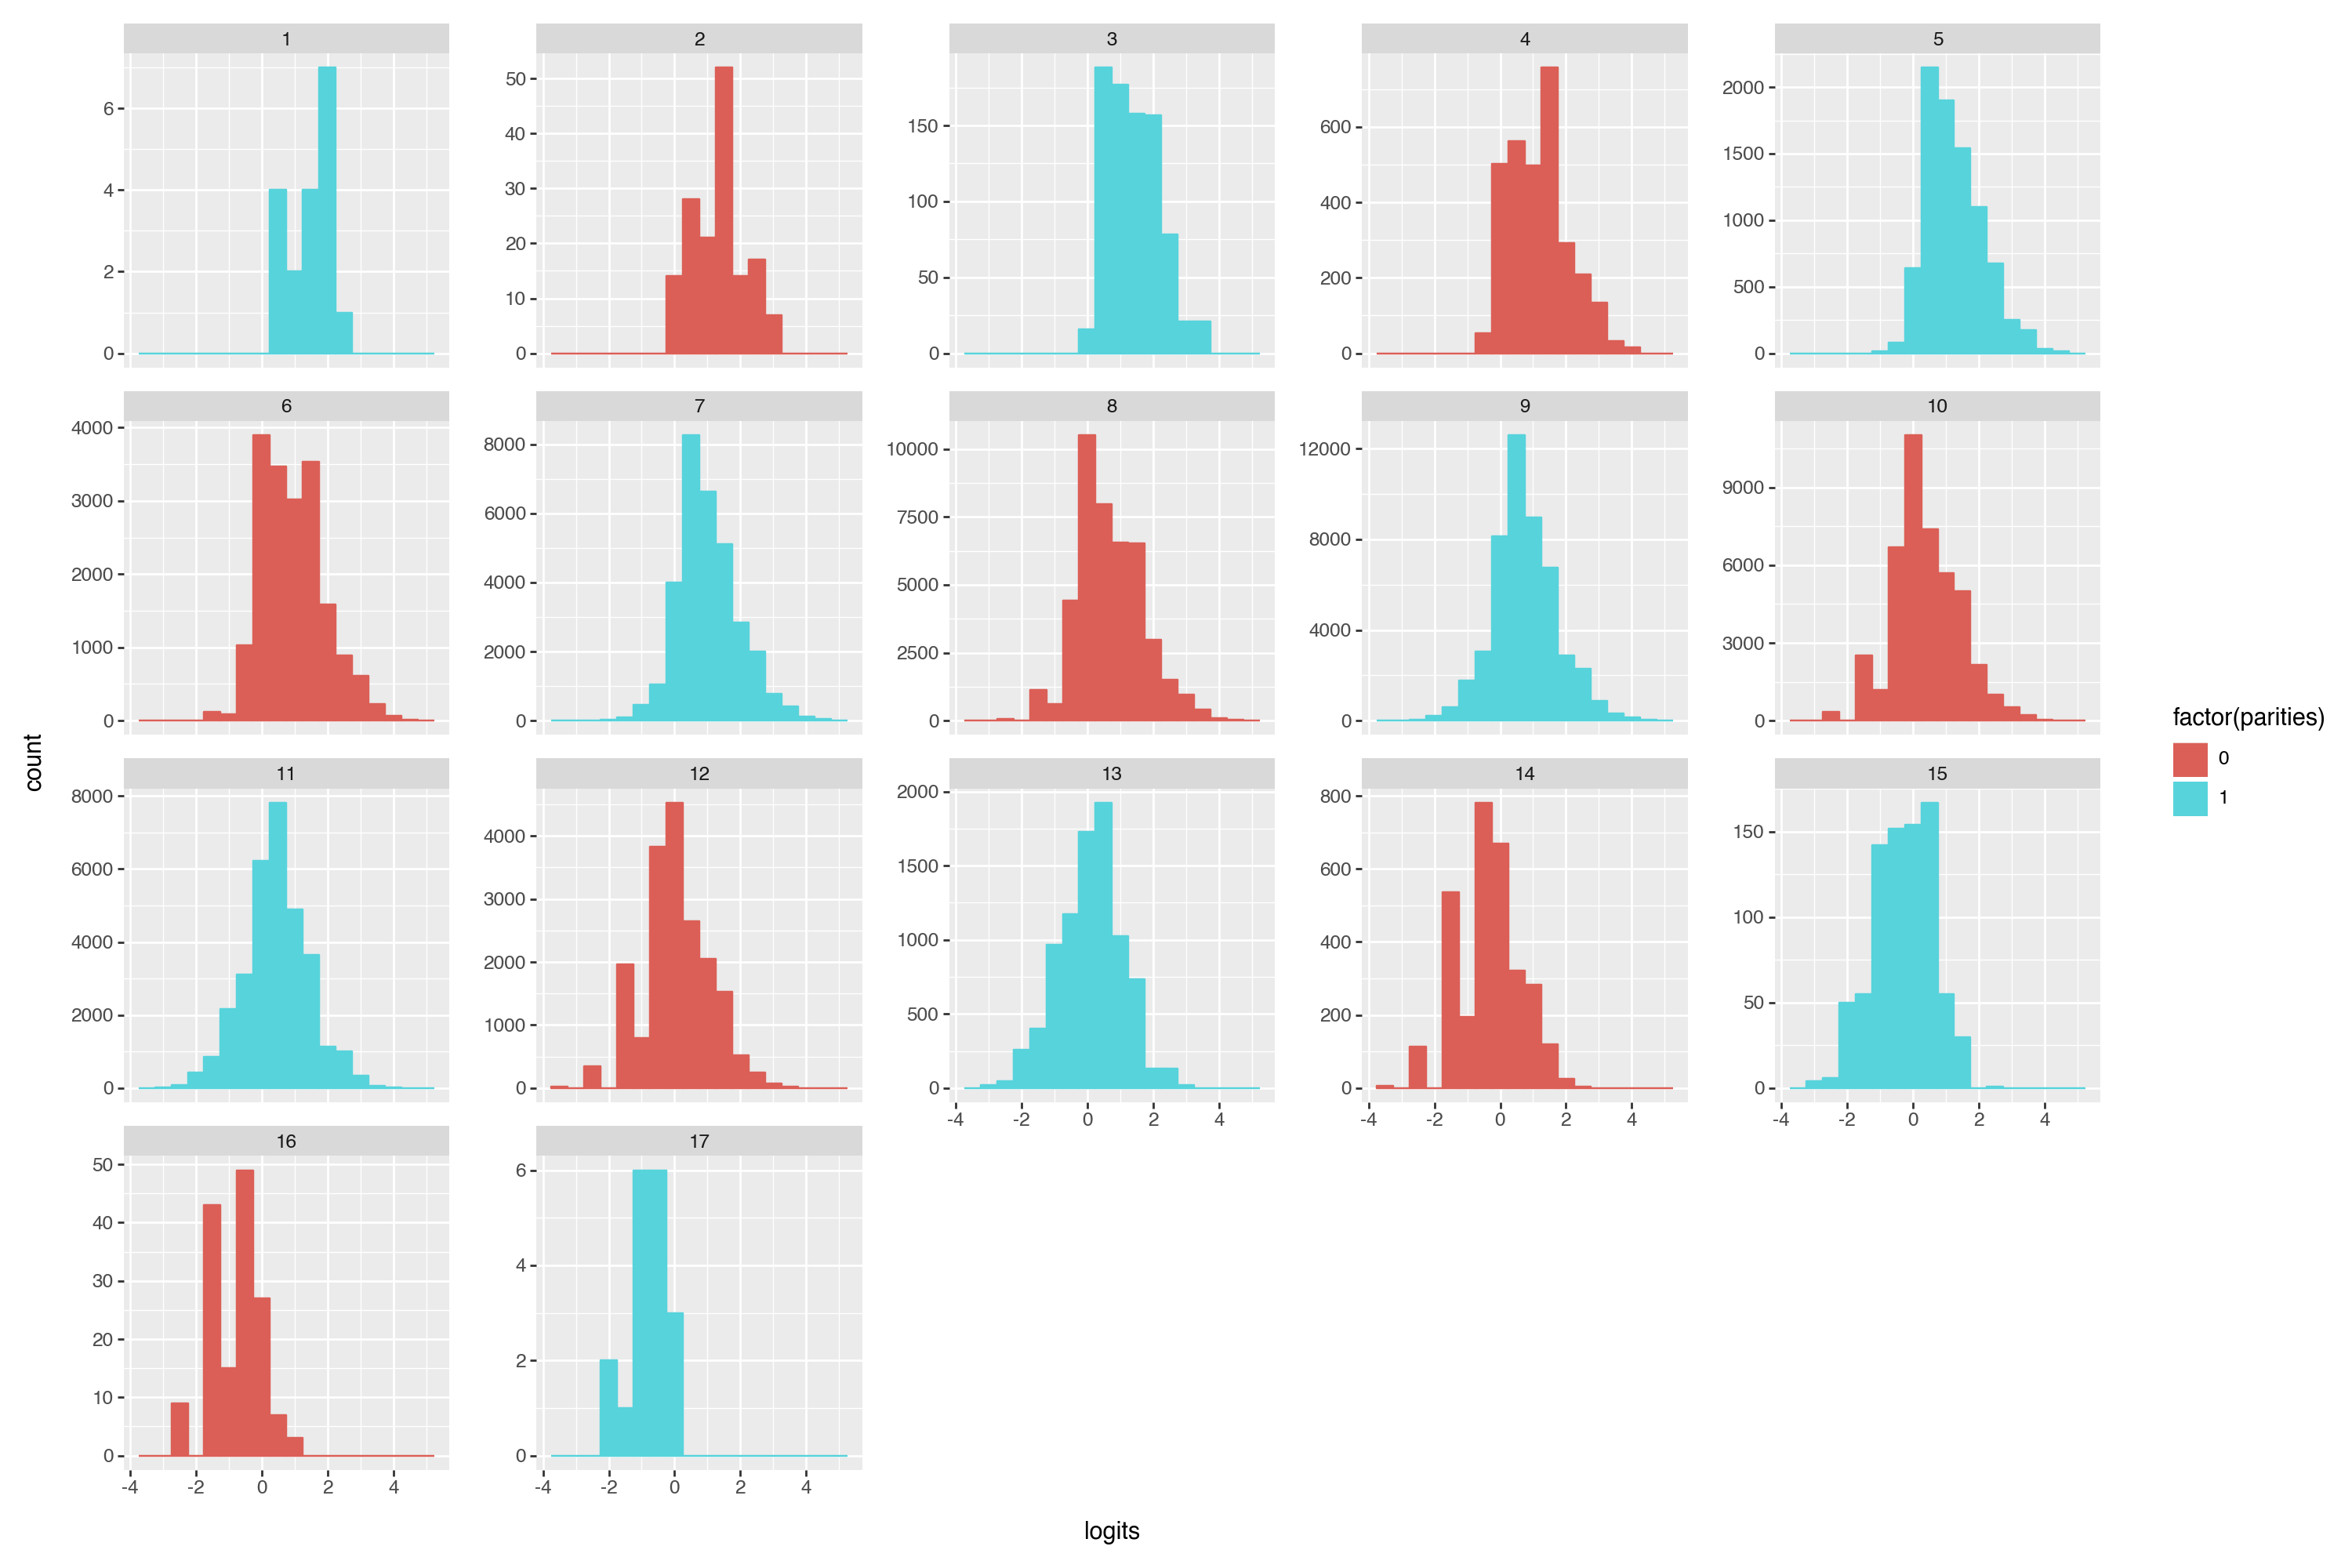

In [51]:
from plotnine import theme, geom_density
from random import choice

i, j, k, l = [choice(maj_cols) for _ in range(4)]

unemb_i = model.unembed.weight[0, i].item()
unemb_j = model.unembed.weight[0, j].item()
unemb_k = model.unembed.weight[0, k].item()
unemb_l = model.unembed.weight[0, l].item()

df = (
    l1_outs_df.select(['parities', 'degree', str(i), str(j), str(k), str(l)])
    .with_columns(
        (pl.col(str(i)) * unemb_i).alias(f'logit{i}'),
        (pl.col(str(j)) * unemb_j).alias(f'logit{j}'),
        (pl.col(str(k)) * unemb_k).alias(f'logit{k}'),
        (pl.col(str(l)) * unemb_l).alias(f'logit{l}'),
    )
    .with_columns(
        logits = pl.col(f'logit{i}') + pl.col(f'logit{j}') + pl.col(f'logit{k}')  + pl.col(f'logit{l}') 
    )
)

signs = torch.sign(model.linear.weight.detach()[[i, j, k, l]])

print(signs @ signs.T)

(
    ggplot(df.filter(pl.col('degree').is_between(1, 17)), aes(x='logits', color ='factor(parities)', fill='factor(parities)')) 
    + geom_histogram(binwidth=0.5)
    + facet_wrap('~degree', scales="free_y")
    + theme(figure_size=(15, 10), )
)

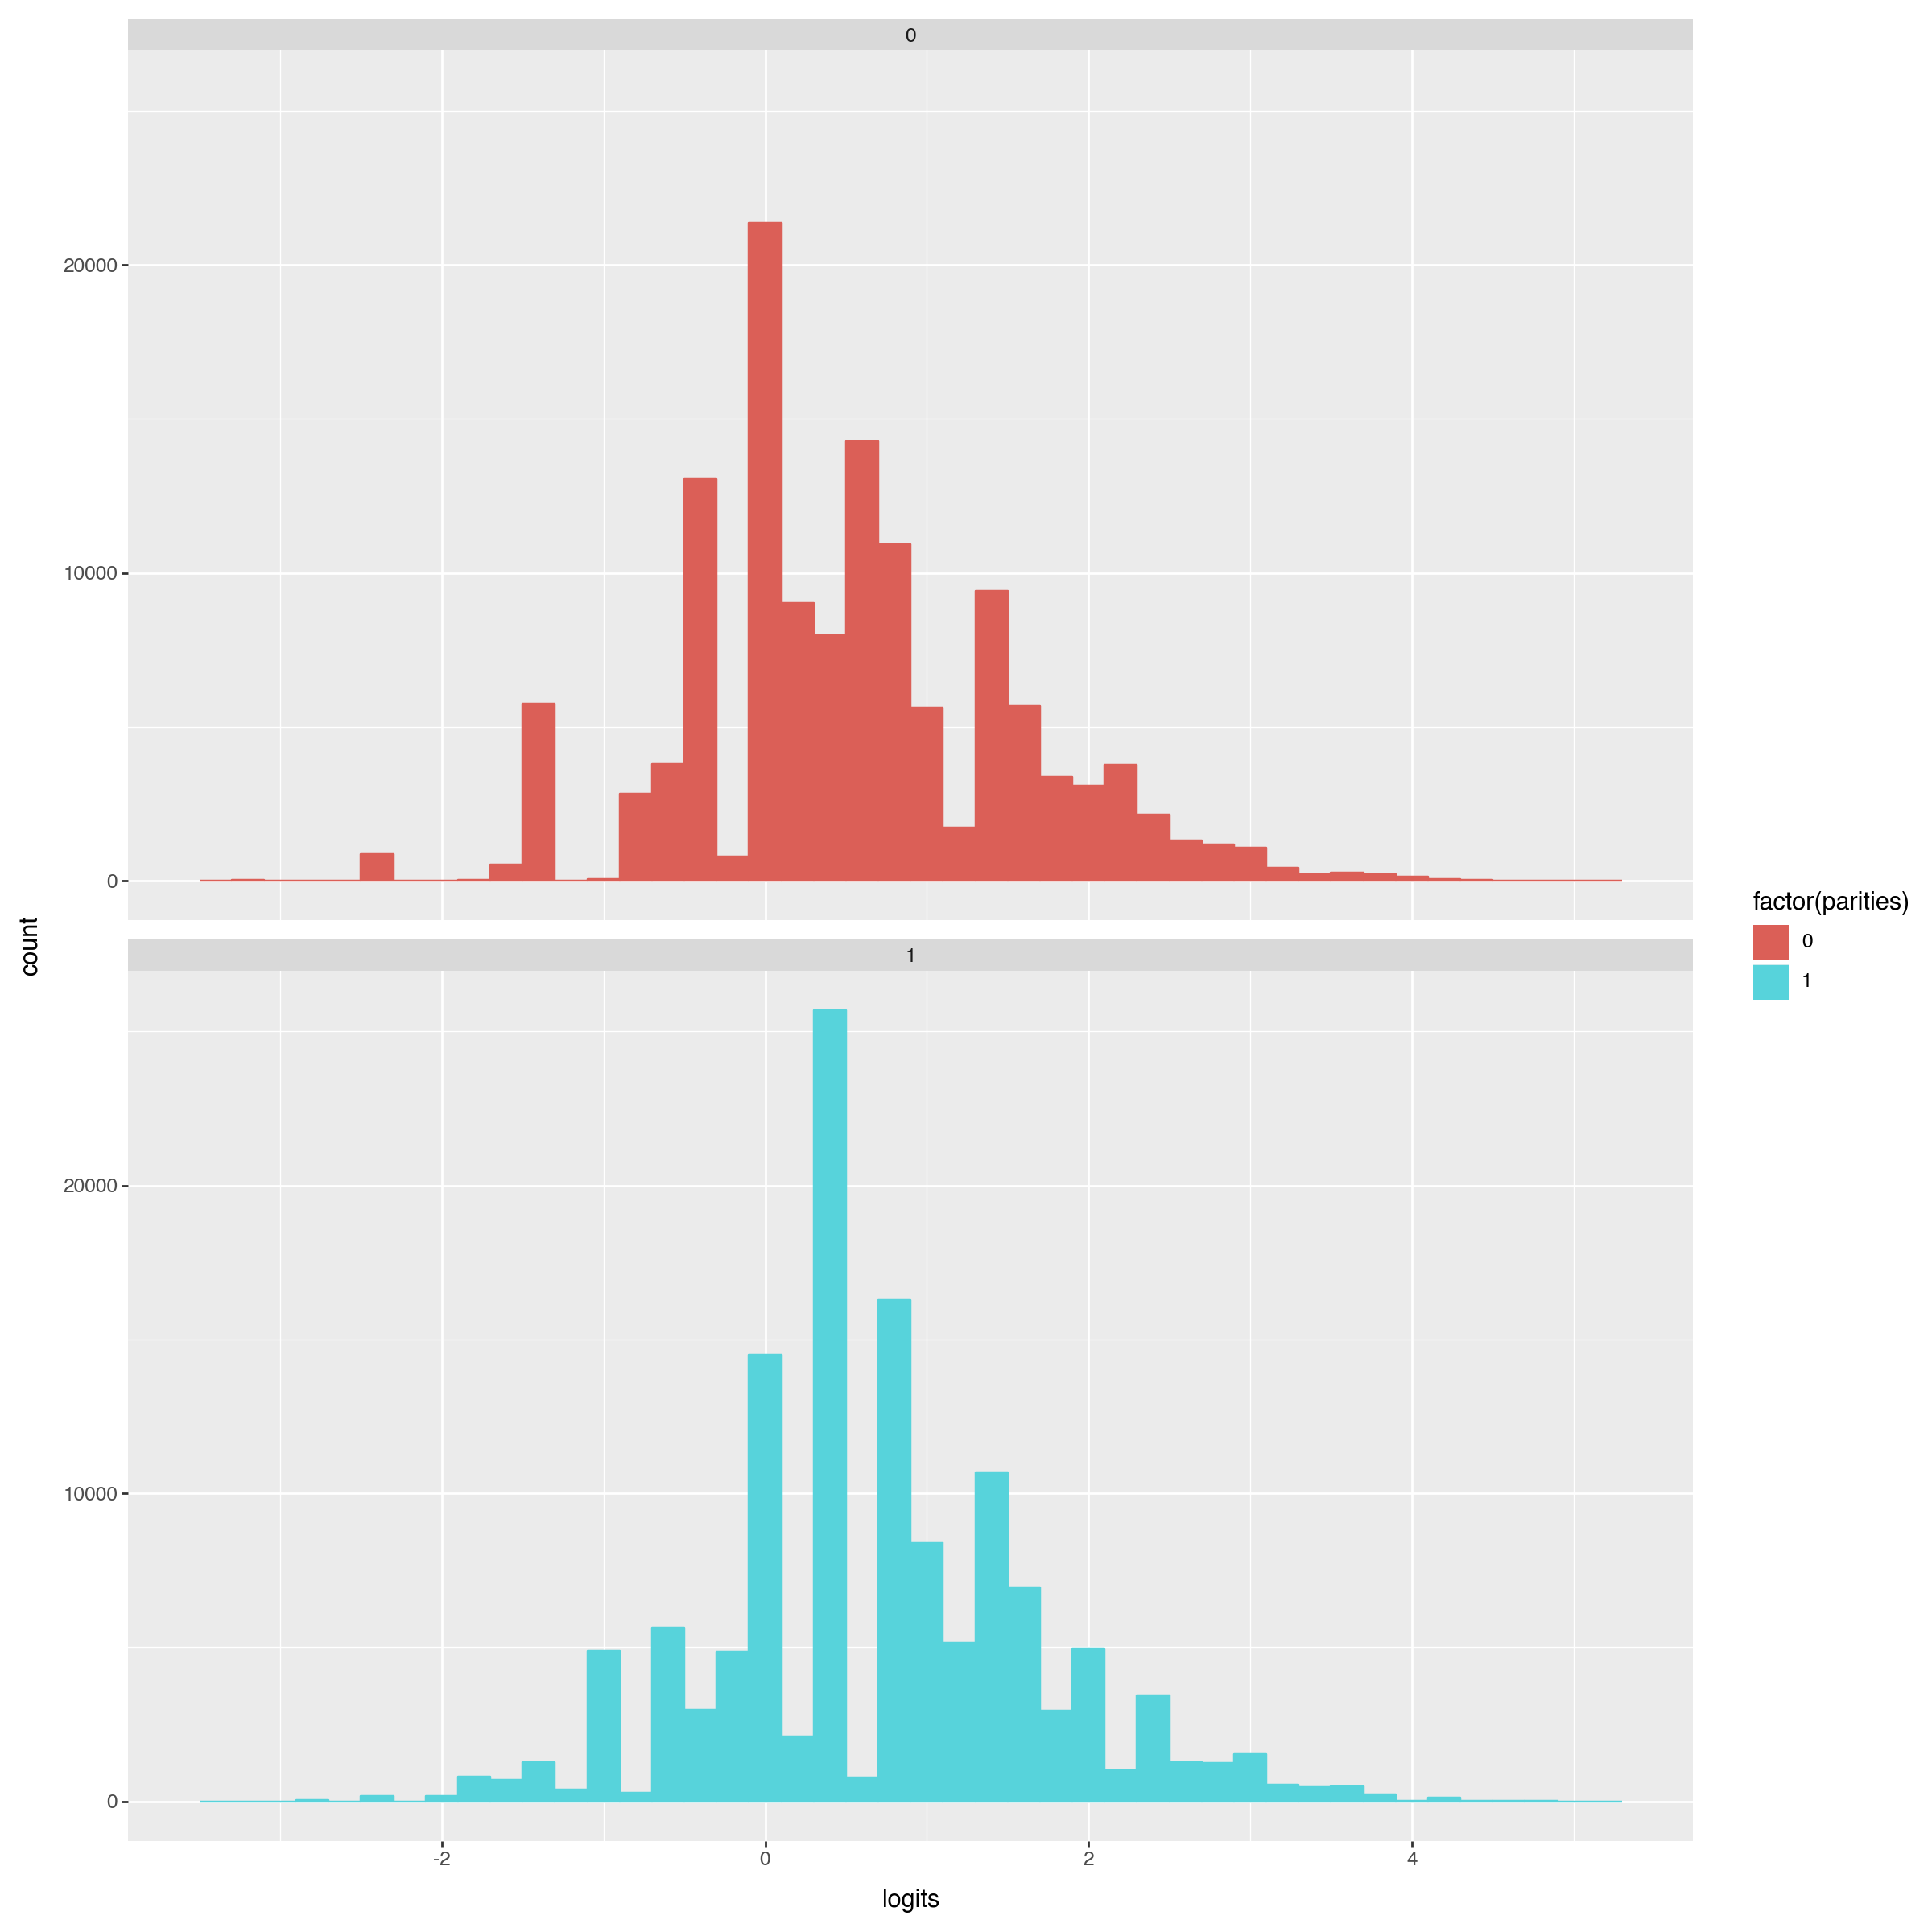

In [77]:
(
    ggplot(df, aes(x='logits', color ='factor(parities)', fill='factor(parities)')) 
    + geom_histogram(binwidth=0.2)
    + theme(figure_size=(12, 12))
    + facet_wrap('~parities', ncol=1)
)

In [ ]:

with pl.Config(tbl_rows=18):
    print(df.filter(pl.col('logits').gt(1)))

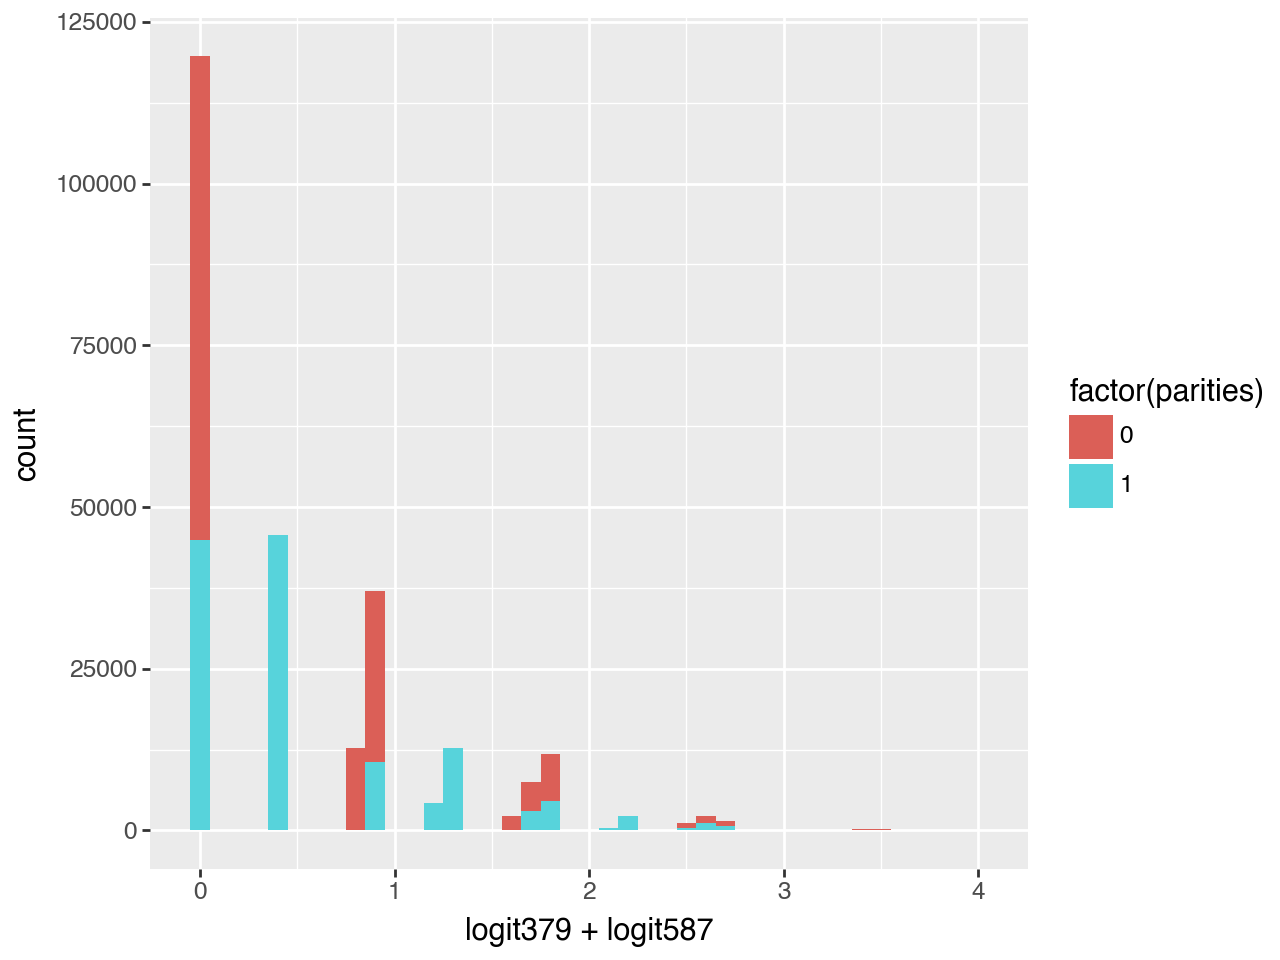

In [62]:
(
    ggplot(df, aes(x=f'logit{i} + logit{k}' , fill='factor(parities)')) 
    + geom_histogram(binwidth=0.1)
)

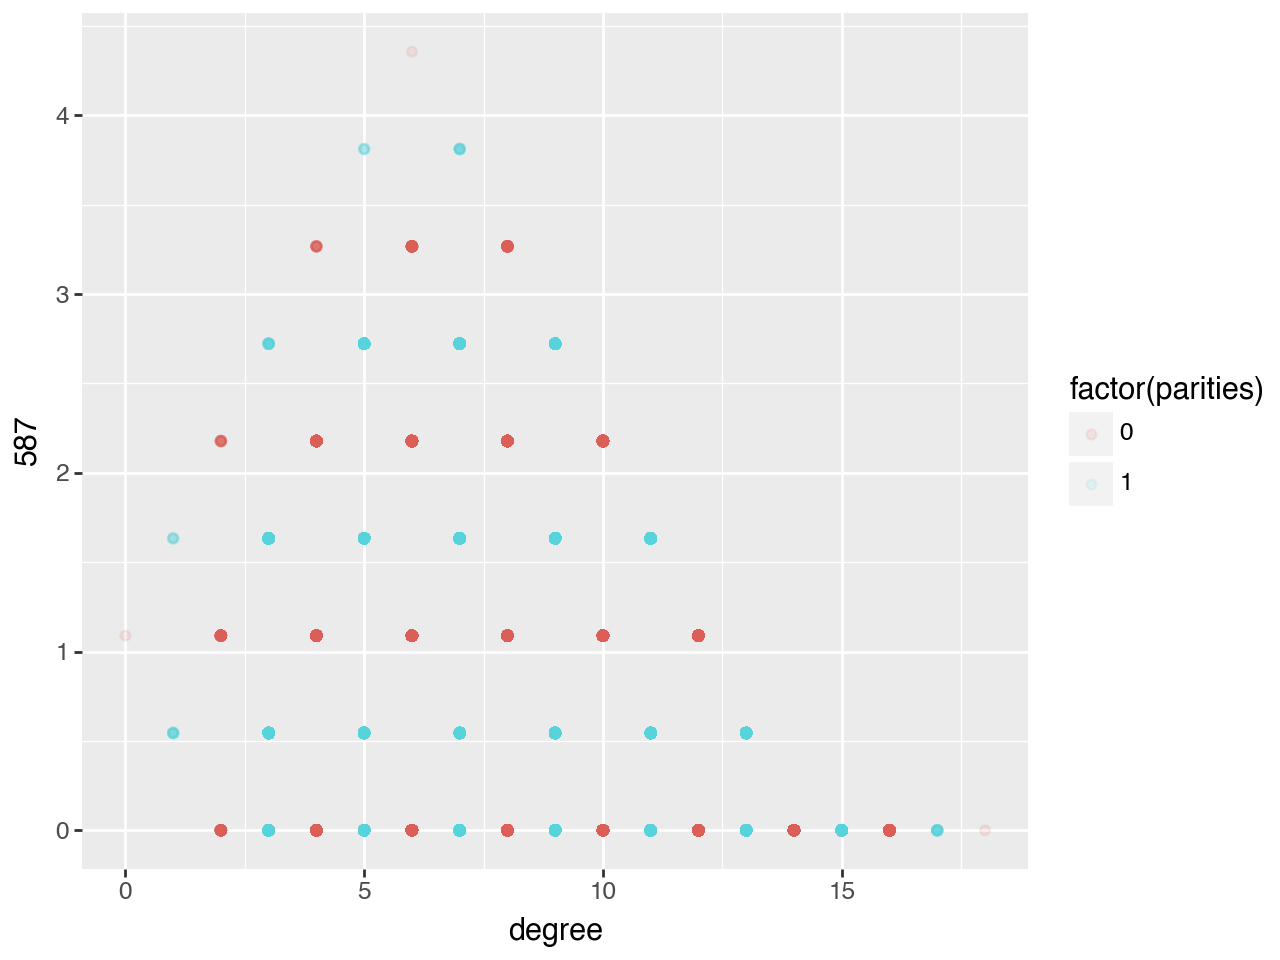

In [74]:
(
    ggplot(df, aes(y=f'{k}', x='degree', color='factor(parities)', fill='factor(parities)')) 
    + geom_point(alpha=0.1)
)

In [73]:
model.linear.weight[l]

tensor([ 0.2866,  0.2866, -0.2866, -0.2866,  0.2866,  0.2866,  0.2866, -0.2866,
        -0.2866, -0.2866, -0.2866,  0.2866,  0.2866,  0.2866, -0.2866,  0.2866,
         0.2866, -0.2866], grad_fn=<SelectBackward0>)

In [68]:
model.linear.weight[k]

tensor([-0.2723, -0.2723, -0.2723, -0.2723,  0.2723,  0.2723, -0.2723,  0.2723,
         0.2723,  0.2723,  0.2723,  0.2723, -0.2723,  0.2723,  0.2723,  0.2723,
         0.2723,  0.2723], grad_fn=<SelectBackward0>)

In [ ]:


def printable_neuron(model, idx):
    wi = model.linear.weight.detach()[idx]
    norm_i = wi.pow(2).sum().sqrt()
    wi /= norm_i
    bias = (model.linear.bias[idx] / norm_i).item()
    unemb = (model.unembed.weight[0, idx] * norm_i).item()
    print(idx, wi, bias, unemb)

printable_neuron(model, i)
printable_neuron(model, j)
printable_neuron(model, k)
printable_neuron(model, l)

In [ ]:
qplot(num_distinct_weights) + geom_histogram(binwidth=1)

In [ ]:
x = np.array([[1, 1, 1, 2, 3, 4], [1, 2, 3, 4, 5, 5]])
np.unique(x, axis=0)

In [ ]:

((model.linear.weight.abs() / model.linear.weight.pow(2).mean(dim=1, keepdims=True)) > 5.5).sum(dim=1) 


In [ ]:
from plotnine import theme

col = 23
x = torch.sign(model.linear.weight[int(col), :])
trans_degree = (boolean_cube @ x).detach().numpy()

df = (
    l1_outs_df.select(['parities', 'degree', str(col)])
    .with_columns(
        trans_degree = trans_degree) 
)

(
    ggplot(df, aes(x='trans_degree', y=str(col), color='factor(parities)')) 
    + geom_point(alpha=0.2)
)

In [ ]:
(
    ggplot(df, aes(x='degree', y=f'{col}', color='factor(parities)')) 
    + geom_point(size=1, alpha=0.1) 
)

In [ ]:
i = int(col)

torch.argwhere((model.linear.weight[i, ] / model.linear.weight[i, ].pow(2).sum()).abs() > 0.5)

In [ ]:
model.linear.bias[i, ]

In [ ]:
qplot(model.linear.bias.detach().numpy()) + geom_histogram()

In [ ]:
cube = torch.from_numpy(generate_all_binary_arrays(8).astype(np.int32))
cube = -1. * torch.sign(cube - 0.5)



In [ ]:
even_degree = torch.zeros(2**8)
y = torch.tensor([1., 1., -1., -1., -1., -1., -1., -1.])


for i, elem in enumerate(cube):
    if elem.sum() == 0:
        even_degree[i] = 1

even_degree = even_degree.unsqueeze(0)


In [ ]:
even_degree

In [ ]:
fourier_transform(even_degree)

In [ ]:
import math 
from torch.nn.functional import relu


def sawtooth(x):
    n = len(x)
    w = torch.ones_like(x) 
    pos_slope = relu(x.dot(w) + 1) - relu(x.dot(w))
    neg_slope = relu(-1. * x.dot(w) + 1) - relu(-1. * x.dot(w))
    return pos_slope/2 + neg_slope/2

small_cube = generate_all_binary_arrays(6).astype(np.int32)
small_cube = -1. * np.sign(small_cube - 0.5)
small_cube = torch.from_numpy(small_cube)

y = [sawtooth(x).item() for x in small_cube]
# n - degree
inv_degree = [(x == 1).sum() for x in small_cube]


qplot(x=degrees, y=y) + geom_line()

In [ ]:
small_cube = generate_all_binary_arrays(6).astype(np.int32)
small_cube = -1. * np.sign(small_cube - 0.5)

In [ ]:
from plotnine import geom_line



In [ ]:
nprelu(-2)